In [50]:
import hoomd
import numpy as np
import math
import itertools
import gsd.hoomd
import os

In [51]:
# Create a custom action class to log energy
class EnergyLogger(hoomd.custom.Action):
    def __init__(self, filename):
        super().__init__()
        # Create the log file with a header
        with open(filename, "w") as f:
            f.write("timestep kinetic_energy potential_energy total_energy\n")
        self.filename = filename
        
    def act(self, timestep):
        # Access the energy values directly from thermodynamic_properties
        ke = self.thermodynamic_properties.kinetic_energy
        pe = self.thermodynamic_properties.potential_energy
        total = ke + pe
        
        # Write to the log file
        with open(self.filename, "a") as f:
            f.write(f"{timestep} {ke} {pe} {total}\n")
    
    def attach(self, simulation):
        # Call the parent attach method to set self._state
        super().attach(simulation)
        # Get a reference to the thermodynamic properties
        self.thermodynamic_properties = None
        for compute in simulation.operations.computes:
            if isinstance(compute, hoomd.md.compute.ThermodynamicQuantities):
                self.thermodynamic_properties = compute
                break


In [ ]:
def create_simulation(N_particles, density, dt, force_magnitude, rotational_diffusion, kT):
    box_volume = N_particles/density
    L = box_volume**(1/3)


    x = np.linspace(-L / 2, L / 2, math.ceil(N_particles ** (1/3)), endpoint=False)
    position = list(itertools.product(x, repeat=3))
    frame = gsd.hoomd.Frame()
    frame.particles.N = N_particles
    frame.particles.position = position[0:N_particles]
    frame.particles.typeid = [0] * N_particles
    frame.particles.types = ["A"]
    frame.particles.moment_inertia = [[1.0, 1.0, 1.0]] * N_particles  # Enable rotation
    frame.configuration.box = [L, L, L, 0, 0, 0]
        # Add random starting orientations
    np.random.seed(42)  # For reproducible results, remove if you want truly random
    random_orientations = []
    for i in range(N_particles):
        # Generate random quaternion by normalizing 4 random numbers
        q = np.random.randn(4)
        q = q / np.linalg.norm(q)  # Normalize to unit quaternion
        random_orientations.append(q)
    
    frame.particles.orientation = random_orientations


    frame.particles.types = ["A"]
    filename="lattice.gsd"
    if os.path.exists(filename):
        os.remove(filename)

    # Now open and write to the file
    with gsd.hoomd.open(name=filename, mode="x") as f:
        f.append(frame)
    
    cpu = hoomd.device.CPU()
    simulation = hoomd.Simulation(device=cpu, seed=1)
    simulation.create_state_from_gsd(filename=filename)

        # Create the integrator
    integrator = hoomd.md.Integrator(dt=dt, integrate_rotational_dof=True)

    if force_magnitude > 0:
        active_filter = hoomd.filter.Type(['A'])
        active_force = hoomd.md.force.Active(filter=active_filter)
        active_force.active_force['A'] = (force_magnitude, 0.0, 0.0)
        active_force.active_torque['A'] = (0.0, 0.0, 0.0)
        integrator.forces.append(active_force)
    
    
    langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=kT)  
    

    langevin.gamma['A'] = 1  
    
    # Rotational diffusion as desired
    langevin.gamma_r['A'] = (rotational_diffusion, rotational_diffusion, rotational_diffusion)
    
    integrator.methods.append(langevin)

    # Set up the neighbor list
    cell = hoomd.md.nlist.Cell(buffer=0.019)  

    # Set up Lennard-Jones potential  
    lj = hoomd.md.pair.LJ(nlist=cell, mode='shift')
    lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
    lj.r_cut[("A", "A")] = 2  

    

    # Add the force to the integrator
    integrator.forces.append(lj)

    # Assign the integrator to the simulation
    simulation.operations.integrator = integrator

    equilibration_steps = 10000  # Let system reach equilibrium
    simulation.run(equilibration_steps)
    equilibration_timestep = simulation.timestep
    # Store positions starting from equilibrated state
    positions = []
    times = []
    
    # Get initial position after equilibration
    snapshot = simulation.state.get_snapshot()
    initial_position = snapshot.particles.position[0].copy()
    positions.append(initial_position)
    times.append(simulation.timestep - equilibration_timestep)  # Reset time reference
    
    # Clean up
    if os.path.exists(filename):
        os.remove(filename)

        # First, set up the thermodynamic properties compute
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All()
    )
    simulation.operations.computes.append(thermodynamic_properties)

    # Create the energy logger
    energy_logger = EnergyLogger(filename="energy.log")

    # Create a custom writer with the energy logger
    energy_writer = hoomd.write.CustomWriter(
        action=energy_logger,
        trigger=hoomd.trigger.Periodic(period=1)
    )

    # Add the writer to the simulation
    simulation.operations.writers.append(energy_writer)
    
    lj_walls = [hoomd.wall.Plane(origin=(0.0, 0.0, -L/2-0.5), normal=(0.0, 0.0, 1.0)),
            hoomd.wall.Plane(origin=(0.0, 0.0, L/2+0.5), normal=(0.0, 0.0, -1.0))]
    shifted_lj_wall = hoomd.md.external.wall.ForceShiftedLJ(walls=lj_walls)
    shifted_lj_wall.params["A"] = {
        "epsilon": 1.0,
        "sigma": 1.0,
        "r_cut": 3.0,
    }
    gauss_walls = [hoomd.wall.Plane(origin=(0.0, 0.0, 0.0), normal=(0.0, 0.0, 1.0)), hoomd.wall.Plane(origin=(0.0, 0.0, 0.0), normal=(0.0, 0.0, -1.0))]
    gauss_wall = hoomd.md.external.wall.Gaussian(walls=gauss_walls)
    gauss_wall.params["A"] = {
    "epsilon": 20.0,
    "sigma": 2.0,
    "r_cut": 5.0,
    }

    integrator.forces.append(shifted_lj_wall)
    integrator.forces.append(gauss_wall)

    gsd_writer = hoomd.write.GSD(filename="trajectory.gsd", 
                            trigger=hoomd.trigger.Periodic(period=100),
                            mode="wb")
    simulation.operations.writers.append(gsd_writer)

    return simulation

In [137]:
def run_simulation():
    """Run the simulation."""
    
    print("Setting up simulation...")
    simulation = create_simulation(N_particles=1000, 
                            density=0.5,  
                            dt=0.0001, 
                            force_magnitude=0, 
                            rotational_diffusion=1, 
                            kT=1
                            )
    
    
    # Production run
    print("Running production...")
    simulation.run(100000)
    
    print("Simulation completed!")
    print("Output files:")
    print("  - energy.log: Energy data")

In [138]:
if __name__ == "__main__":
    run_simulation()

Setting up simulation...
Running production...
Simulation completed!
Output files:
  - energy.log: Energy data


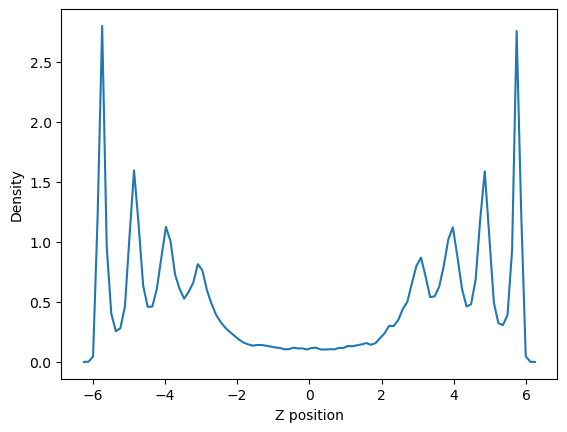

In [139]:
import freud
import gsd.hoomd
import numpy as np

def analyze_density_profile(trajectory_file, bins=20):
    """Analyze density profiles from saved trajectory."""
    densities_z = []
    
    with gsd.hoomd.open(trajectory_file, 'r') as traj:
        for frame in traj:
            box = frame.configuration.box
            positions = frame.particles.position
            
            # Create z-density profile
            z_coords = positions[:, 2]
            hist, bin_edges = np.histogram(z_coords, 
                                         bins=bins, 
                                         range=(-box[2]/2, box[2]/2))
            
            # Convert to density
            bin_width = bin_edges[1] - bin_edges[0]
            bin_volume = box[0] * box[1] * bin_width  # Assuming uniform xy
            density = hist / bin_volume
            
            densities_z.append(density)
    
    return np.array(densities_z), bin_edges

# Usage:
densities, z_bins = analyze_density_profile("trajectory.gsd", bins=100)
average_density = np.mean(densities, axis=0)

# Plot
import matplotlib.pyplot as plt
z_centers = (z_bins[1:] + z_bins[:-1]) / 2
plt.plot(z_centers, average_density)
plt.xlabel('Z position')
plt.ylabel('Density')
plt.show()